<a href="https://colab.research.google.com/github/Staticstic/Data-Analysis-practice/blob/main/Anomaly%20detection%20analysis%20practice/%EA%B1%B0%EB%9E%98_%EC%82%AC%EA%B8%B0_%ED%83%90%EC%A7%80_%ED%8C%8C%EC%95%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **거래 사기 탐지 파악**
---

* 데이터 ⬇

|Column|Description|
|:---|:---|
|step|1step이 1시간인 시간 단위|
|type|온라인 거래유형|
|amount|거래 금액|
|nameOrig|거래 시작 고객|
|oldbalanceOrg|거래 전 잔액|
|newbalanceOrig|거래 후 잔액|
|nameDest|거래 수신 고객|
|oldbalanceDest|거래 전 수취인의 초기 잔액|
|newbalanceDest|거래 후 받는 사람의 새 잔액|
|isFraud|사기 거래|
|isFlaggedFraud|의심사기거래|


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 데이터 파악

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Data/transaction')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
# Row : 6362620, Column : 11
df.shape

(6362620, 11)

In [9]:
# Data type 확인
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [10]:
# Data 분포 확인
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [11]:
# Null값은 없는 것으로 확인
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [12]:
# 사기율은 약 0.13%로 매우 적다.(0과 1의 불균형이 심한 자료)
df['isFraud'].value_counts(normalize=True)*100

isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64

In [13]:
# 거래 유형이 Transfer 인 경우, 0.77%로 가장 높았고, Cash out이 0.18%로 뒤를 이었다. 나머지 거래 방법은 사기 건수가 발생하지 않았다.
(df.groupby('type')['isFraud'].mean().sort_values(ascending=False)*100).reset_index()

,type,isFraud
0,TRANSFER,0.768799
1,CASH_OUT,0.183955
2,CASH_IN,0.000000
3,DEBIT,0.000000
4,PAYMENT,0.000000


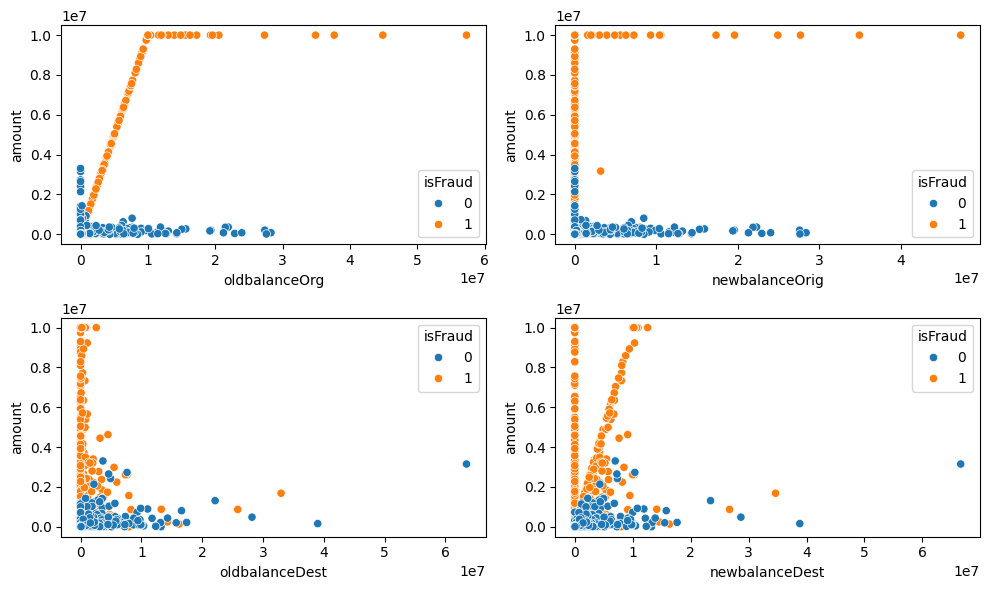

In [14]:
# 사기거래와 사기거래가 아닌 거래의 amount의 분포를 비교

# isFraud가 1과 0인 데이터 1000개씩 각각 생성
fraud_sample = df[df['isFraud'] == 1].sample(n=1000, random_state=2024)
non_fraud_sample = df[df['isFraud'] == 0].sample(n=1000, random_state=2024)

# 두 데이터셋 병합
data = pd.concat([fraud_sample, non_fraud_sample])

# 데이터 시각화
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
sns.scatterplot(data=data, x='oldbalanceOrg', y='amount', hue='isFraud')

plt.subplot(2, 2, 2)
sns.scatterplot(data=data, x='newbalanceOrig', y='amount', hue='isFraud')

plt.subplot(2, 2, 3)
sns.scatterplot(data=data, x='oldbalanceDest', y='amount', hue='isFraud')

plt.subplot(2, 2, 4)
sns.scatterplot(data=data, x='newbalanceDest', y='amount', hue='isFraud')

plt.tight_layout()
plt.show()

위의 시각화를 통해 다음과 같은 점을 생각해볼 수 있다.
- 사기 거래는 주로 거래 금액이 큰 경우에 많이 일어난다.
- 사기 거래는 거래 후 잔액(newbalanceOrig)이 0인 경우가 많았다. 이는 사기꾼이 거래 후 다른 계좌로 돈을 송금하기 때문인 것으로 추측해볼 수 있다.

### 데이터 전처리

In [15]:
# 필요 없는 변수 삭제
df = df.drop(['nameOrig', 'nameDest'],axis=1)

In [16]:
# 수치형, 범주형 변수 나눠서 저장
num_list=[]
cat_list=[]

for i in df.columns :
  if df[i].dtypes == 'O' :
    cat_list.append(i)
  else :
    num_list.append(i)

print("categorical_list :", cat_list)
print("numerical_list :", num_list)

categorical_list : ['type']
numerical_list : ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


In [17]:
# 범주형 변수 OneHotEncoding
from sklearn.preprocessing import OneHotEncoder

for col in cat_list :
  encoder = OneHotEncoder()
  onehot_df = pd.DataFrame(encoder.fit_transform(df[[col]]).toarray(), columns = encoder.get_feature_names_out())
  # 기존 column 삭제
  df = pd.concat([df,onehot_df], axis = 1).drop(columns = [col])

df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0.0,0.0,0.0,0.0,1.0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0.0,1.0,0.0,0.0,0.0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0.0,0.0,0.0,1.0,0.0


In [18]:
# train, test split
from sklearn.model_selection import train_test_split

X=df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y=df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=725)

### 모델링 학습

In [19]:
from sklearn.ensemble import IsolationForest

# n_estimators : 나무의 개수 (※ default 100)
# max_samples : 샘플링 데이터 개수 (※ 정수, 실수(0~1), 전체 데이터 개수 or 256 중 작은 수)
# contamination : 전체 데이터에서 이상치의 비율, 이 비율에 따라 이상치로 판단하기 위한 score의 threshold를 정의
# max_features : 학습 시 사용할 Feature (※ default 1, 모두 사용)

model = IsolationForest(max_samples=200, contamination = 0.002, random_state=725)
model.fit(X_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [20]:
# isolation forest는 1, -1을 결과로 출력하므로 -1을 0으로 변환
y_pred_train = np.where(y_pred_train==-1, 1, 0)
y_pred_test = np.where(y_pred_test==-1, 1, 0)

In [21]:
# 성능평가
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.01      0.02      0.02      1643

    accuracy                           1.00   1272524
   macro avg       0.51      0.51      0.51   1272524
weighted avg       1.00      1.00      1.00   1272524



비지도 학습 기반의 모델링을 했을 때 성능이 좋지 않게 나왔다.   
따라서 지도학습의 기반의 예측 모델 방법을 선택해보았다.

In [22]:
# 오버 샘플링 진행
from imblearn.over_sampling import SMOTE

# SMOTE 적용
smote = SMOTE(random_state=725)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [25]:
# light GBM 사용하여 모델 학습
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train_over, y_train_over)

[LightGBM] [Info] Number of positive: 5083526, number of negative: 5083526
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.035971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2046
[LightGBM] [Info] Number of data points in the train set: 10167052, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


array([0, 0, 0, ..., 0, 0, 0])

In [26]:
# 성능평가
y_pred_test_lgbm = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred_test_lgbm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.24      0.99      0.39      1643

    accuracy                           1.00   1272524
   macro avg       0.62      0.99      0.69   1272524
weighted avg       1.00      1.00      1.00   1272524

